In [1]:
#| default_exp clean

# Sections

> Module for creating chunks of the transcript, for both paragraphs and topics.

In [2]:
#| export
import json
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import download

In [3]:
#| export 
download('punkt')
download('stopwords')

[nltk_data] Downloading package punkt to /home/steph/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/steph/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
with open("../data/podcast/lex_ai_stephen_wolfram_1/transcript-whisperx.json") as f:
    transcript = json.load(f)

# Preprocessing

This notebook will deal with 'cleaning' the transcribed text to be fed into our topic model / summarisation section splitters.

There are a number of methods that can be applied in order to clean the text, but it's worth thinking about which is actually necessary.

### Preprocessing Steps

- consistent sentence length
- remove punctuation
- remove capitalisation
- remove numbers
- remove stopwords
- remove speech filler words ('ah', 'uhm', etc.)
- lemmatize words

### Preserving Original

What also needs to be ensured is that the original text can be preserved, for the final output. The answer to this is simply, splits are to be done at the sentence level, on the indexes of the sentences. So long as the indexes are noted, the original text can easily be retrieved for each sentence.

## Exploration

### Cleaning Effects

Each sentence will be embedded into vectors, so one way of seeing which cleaning is required is to have a look at how much the vectors change within these.

In [6]:
#| export
def get_indexed_sentences(text, min_length=10):
    sentences = []; sentence = []; index = 0
    for i, word in enumerate(text.split(' ')):
        sentence.append(word)
        word = word.replace('?', '.')
        if (word.endswith('.') or word.endswith('. ')) and len(sentence) > min_length: 
            sentences.append({
                'index': index,
                'text': ' '.join(sentence)
                })
            sentence = []
            index = i+1
    return sentences

In [7]:
sentences_indexed = get_indexed_sentences(transcript['text'])
sentences = [ s['text'] for s in sentences_indexed ]

In [8]:
sentences[0]

'The following is a conversation with Stephen Wolfram, his fourth time on this podcast.'

In [9]:
from sentence_transformers import SentenceTransformer

sentence_model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

/home/steph/.conda/envs/transcriber/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
sentence_embeddings = sentence_model.encode(sentences)
sentence_embeddings.shape

(1758, 768)

In [11]:
#| export
def remove_punctuation(text): #todo check if this removes any helpful punctuation (ie. individual characters such as "-")
    return text.translate(
        str.maketrans('', '', string.punctuation)
    )

def lower_case(text): return text.lower()

def remove_numbers(tokens): return [ word for word in tokens if word.isalpha() ]

def remove_stopwords(tokens):
    stop_words = set(stopwords.words('english'))
    return [ word for word in tokens if not word in stop_words ]

In [12]:
#| export
def clean(text):

    # removing punctuation and upper cases
    text = lower_case(
        remove_punctuation(
            text
        ))
    
    # tokenisation
    tokens = word_tokenize(text)

    # removing stopwords and numeric tokens
    stop_words = set(stopwords.words('english'))
    tokens_cleaned = [
        token for token in tokens
        if token.isalpha() and token not in stop_words
    ]

    # lemmatizing words
    lemma = WordNetLemmatizer()
    lemmatized = [ lemma.lemmatize(token) for token in tokens_cleaned ]

    return " ".join(lemmatized)

In [13]:
sentences_cleaned = [ clean(s) for s in sentences ]

In [14]:
cleaned_sentence_embeddings = sentence_model.encode(sentences_cleaned)

In [15]:
with open("../data/podcast/lex_ai_stephen_wolfram_1/tmp/transcript-cleaned.json", "w") as f:
    json.dump(sentences_cleaned, f, ensure_ascii=False, indent=2)

In [16]:
embeddings_diff = (sentence_embeddings - cleaned_sentence_embeddings) / sentence_embeddings
embeddings_diff.shape

(1758, 768)

In [17]:
embeddings_diff_mean = np.mean(embeddings_diff, axis=0)
embeddings_diff_mean.shape

(768,)

In [18]:
np.mean(embeddings_diff_mean), np.sort(embeddings_diff_mean)[:5], np.sort(embeddings_diff_mean)[-5:]

(0.38511392,
 array([-65.19832 , -55.083336, -43.02101 , -29.795107, -29.490257],
       dtype=float32),
 array([ 23.76629 ,  33.80281 ,  52.081417,  66.8239  , 104.467094],
       dtype=float32))

In [19]:
np.std(embeddings_diff_mean)

7.376935

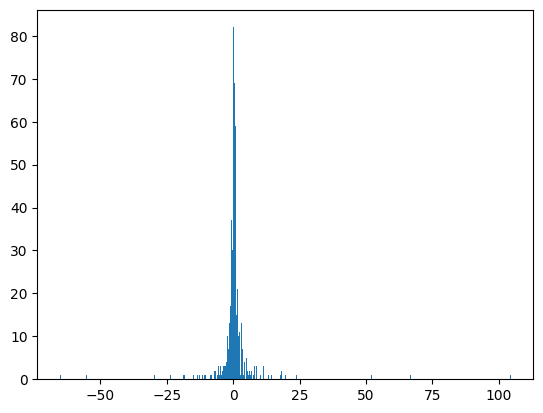

In [20]:
plt.hist(embeddings_diff_mean, bins=700);

That's quite a large difference in changes meaned over. 

However this mean looks to be quite heavily affected by outliers. 

Is there anything that I'd lose from cleaning the dataset beforehand? Maybe not.

## Checks

### Space Characters

Only some segments in segment groups start with spaces.

Where does this come from? The speaker group split? The diarization alignment? Whisperx?

In [21]:
indices = []
for i_g, g in enumerate(transcript['speech_segments']):
    for i_s, s in enumerate(g['segments']):
        if s['text'].startswith(' '):
            indices.append({
                'g': i_g, 's': i_s
            })

indices[:5]

[{'g': 0, 's': 0},
 {'g': 0, 's': 2},
 {'g': 0, 's': 3},
 {'g': 0, 's': 8},
 {'g': 0, 's': 17}]

Investigating why whisper only adds initial spaces occassionally to segments. This happens at the whisper level. 

In [22]:
with open(("../data/podcast/lex_ai_stephen_wolfram_1/transcript-whisperx.json"), 'r') as f:
    transcript_whisper = json.load(f)

In [23]:
arrayed_text = [ segment['text'] for segment in transcript_whisper ]
for text in arrayed_text:
    if not text.startswith(' '): print(text)

-> Turns out whisper adds it to every segment of speech.

### Missing Text

Investigating if any parts of text is removed unnecessarily.

In [24]:
text = transcript['text']

text = remove_punctuation(
        text
    )
tokens = word_tokenize(text)

text_array = text.split(' ')
diffs = [ 
    (i, word) for i, word in enumerate(text_array) 
        if word not in tokens 
]

print(len(text_array), len(tokens), diffs)

45115 45173 [(457, 'wanna'), (2929, 'gonna'), (2945, 'gonna'), (2992, 'gonna'), (3163, 'gonna'), (3181, 'gonna'), (3287, 'gonna'), (3298, 'gonna'), (3501, 'gonna'), (3555, 'gonna'), (4157, 'wanna'), (6803, 'gonna'), (9477, 'gonna'), (12257, 'gonna'), (12320, 'gonna'), (14328, 'gonna'), (14336, 'gonna'), (15571, 'gonna'), (16714, 'gonna'), (16724, 'gonna'), (17066, 'gonna'), (17195, 'gonna'), (17377, 'gonna'), (17616, 'gonna'), (19198, 'gonna'), (19426, 'gonna'), (19937, 'gonna'), (20134, 'gonna'), (21267, 'gonna'), (22201, 'gonna'), (22591, 'gonna'), (23254, 'gonna'), (23645, 'gonna'), (23652, 'gonna'), (24126, 'gonna'), (24753, 'gonna'), (26401, 'gonna'), (26464, 'gonna'), (27819, 'gonna'), (27826, 'gonna'), (28151, 'gonna'), (29243, 'gonna'), (31413, 'gonna'), (31438, 'gonna'), (31751, 'wanna'), (32822, 'gonna'), (32897, 'gonna'), (35103, 'gonna'), (37972, 'gonna'), (37980, 'wanna'), (39015, 'cannot'), (40359, 'gonna'), (40367, 'gonna'), (40400, 'gonna'), (41696, 'gonna'), (43383, 'g

In [25]:
diffs_context = [ ' '.join(text_array[index-5:index+5]) for index, word in diffs ]
diffs_context[:5]

['excellent Gene Goodall If you wanna check it out go',
 'you have a program youre gonna run it you might',
 'I know everything about whats gonna happen Well in principle',
 'and say I know whats gonna happen after a million',
 'can figure out what its gonna do It does those']

In [26]:
tokens[455:460], text_array[455:460]

(['If', 'you', 'wan', 'na', 'check'], ['If', 'you', 'wanna', 'check', 'it'])

Here it can be seen that the tokeniser struggles a bit when it comes to conversational words like 'wanna' and 'gonna'. It turns them into seperate tokens, which I'm not sure if the topic model will be able to understand or make use of properly. It might be a good idea to change the style to formal instead. I'm seeing a model [StyleFormer](https://github.com/PrithivirajDamodaran/Styleformer#casual-to-formal--available-now---) which can do just this.

## Complete

I don't think it's best to remove punctuation - "'" in particular. Words such as we'll will get tokenised as 'well' which could have an effect.

In [27]:
tokenised_sentences = [ clean(sentence) for sentence in transcript['text'].split('. ') ]
tokenised_sentences[0]

'following conversation stephen wolfram fourth time podcast'

# Preprocessing Text

In [28]:
# creating min_sentence length as this can interfere with clustering
# eg. clusering which take into account similar words, there's less of a chance if there are less words
def split_sentences(text, min_length):
    sentences = text.split(". ")
    sentences = [ ([i], s) for i, s in enumerate(sentences) ]
    pop_indices = []
    for indices, s in sentences:
        idx = indices[0]
        if idx >= (len(sentences)-1): break
        if len(s.split(" ")) < min_length:
            sentences[idx+1] = (
                [*sentences[idx+1][0], *indices],
                sentences[idx+1][1] + " " + s
            )
            pop_indices.append(idx)
    sentences = [ s for i, s in enumerate(sentences) if i not in pop_indices ]
    return sentences

In [29]:
sentences = split_sentences(transcript['text'], 10)

In [30]:
assert len([ s for s in sentences if len(s[1].split(" ")) < 10 ]) == 0

In [31]:
sentences_clean = [ clean(sentence) for idx, sentence in sentences ]

In [32]:
sentences_clean[:5]

['following conversation stephen wolfram fourth time podcast',
 'he computer scientist mathematician theoretical physicist founder wolfram research company behind mathematica wolfram alpha wolfram language wolfram physic metamathematics project',
 'pioneer exploring computational nature reality he perfect person explore together new quickly evolving landscape large language model human civilization journey towards building super intelligent agi',
 'quick second mention sponsor',
 'best way support podcast check description']

In [33]:
with open("../data/podcast/lex_ai_stephen_wolfram_1/tmp/transcript-cleaned.json", "w") as f:
    json.dump(sentences_clean, f, ensure_ascii=False, indent=2)

In [34]:
#| hide
from nbdev import nbdev_export
nbdev_export()